## Задача № 3 (для 2 курса)
 
Название: Автоматизация обработки машиночитаемых документов.
 
Описание: Вам будет выдан набор данных документов из системы документооборота небольшой вымышленной компании. На основе этого набора данных вам нужно построить граф знаний о компании, который включает:

● 	Организационную структуру (список подразделений). Есть

● 	Список сотрудников 

●  и их должностей. 

● 	Должностные обязанности и полномочия сотрудников.

На основе построенного графа знаний нужно разработать систему, которая ищет ошибки в проверочных документах (10 правильных документов, 10 документов с ошибками), например:

● 	Опечатки в названиях подразделений или ФИО сотрудников.

● 	Несуществующие подразделения или сотрудники, ошибки в должностях.

● 	Несоответствие тематики документа подразделению, в которое он направлен для исполнения (в бухгалтерию направлен документ с задачей по ИТ).
 
Ссылка на набор данных – https://www.dropbox.com/sh/d5h5f3yrql8x392/AACQ2WYa5qYCqjC8QuVZ5TJ4a?dl=1 

Вам будет передана открытая часть датасета с разметкой, закрытая часть датасета без разметки и проверочные документы (20 документов для подзадачи обнаружения ошибок в документах).
 
Требования к решению:
1.   Код программы построения графа знаний о компании (ссылка на GitHub), с помощью которого можно ответить на вопросы:
a.   Количество отделов.
b.   Количество сотрудников.
c.	К какому отделу относится конкретная задача.
2.   Код программы поиска документов с ошибками на основе графа знаний (ссылка на GitHub).
3.   Документы, в которых найдены ошибки.
 
Критерии оценки:
● 	За каждый найденный документ с ошибкой начисляется 10 баллов.
● 	За каждый документ, представленный как ошибочный, но в котором ошибки на самом деле нет, назначается штраф -1 балл.
 
Советы по реализации:
1.   Извлечь именованные сущности (NER) из текста можно с помощью библиотеки spacy (https://spacy.io/), pullenti, natasha или соответствующих моделей с huggingface (https://huggingface.co/).
2.   Для сущностей, для которых не удастся найти типовые предобученные модели (например, сущность «Задача» или «Департамент») организовать обучение модели с использованием открытой части датасета.
3.   Для построения графа связей в организации рекомендуется использовать библиотеку NetworkX - https://networkx.org/

# Решение.

1. task_text: разбить на предложения. Выявить функционал. FIO_POSITION: ФИО, должность, функционал, отдел (не необходимо).
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.

### Устанавливаем библиотеки

In [100]:
!pip install nltk
!pip install navec
!pip install pandas
!pip install natasha
!pip install matplotlib
!pip install python-docx
!pip install scikit-learn

!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

!pip install networkx
#!pytest networkx
#!pytest --pyargs networkx

!pip install pymorphy2

2023-01-22 19:42:34.359150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 19:42:37.173052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 19:42:37.173081: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-22 19:42:43.408791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [101]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import download
from nltk.tokenize import sent_tokenize, word_tokenize

from navec import Navec
from docx import Document
from IPython.display import display
from sklearn.model_selection import train_test_split

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
    Doc
)

from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, GRU
from keras.preprocessing.text import Tokenizer

# Морфологический анализ
from pymorphy2 import MorphAnalyzer

# Синтаксический анализ
from spacy import load

In [102]:
with open('merged_data.json', "r") as readFile:
    merge_data = json.load(readFile)

### Определяем количество департаментов в компании

In [103]:
DEPARTMENTS = []
for n in range(10000):
    try:
        for i in range(1,30):
            DEPARTMENTS.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_groups'])
    except KeyError:
        continue
    except IndexError:
        continue

In [104]:
FIO_POSITION = []
for n in range(10000):
    try:
        for i in range(1,20):
            FIO_POSITION.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_people'])
    except KeyError:
        continue
    except IndexError:
        continue

In [105]:
TASK = []
for n in range(10000):
    try:
        for i in range(1,30):
            TASK.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_text'])
    except KeyError:
        continue
    except IndexError:
        continue

In [106]:
POSITION = []
for n in range(10000):
    try:
        for i in range(1,30):
            POSITION.append(merge_data[n]['Tasks']['Global_supervisor'][i])
    except KeyError:
        continue
    except IndexError:
        continue

### Очищаем данные

In [107]:
def text_split(text: str):
    pouch_of_words = []
    for line in text:
        line = line.split()
        pouch_of_words.append(line)
    return pouch_of_words

In [108]:
pouch_of_words = text_split(FIO_POSITION[:2])

In [194]:
def split_spacy(text: str):
    pouch_of_words = []
    nlp = load('ru_core_news_sm')
    if type(text) == list:
        for line in text:
            doc = nlp(line)
            for token in doc:
                pouch_of_words.append(token)
    return pouch_of_words

In [195]:
def sentence(text: str):
    download('punkt')
    sentences = sent_tokenize(text)
    return sentences

### Морфологический анализ

In [196]:
morph = MorphAnalyzer()

In [197]:
def morph_word(words: str):
    words = split_spacy(words)
    morph_words = []
    for word in words:
       print(word)

morph_word(POSITION[:1])

Контроль
над
выполнением
приказа
возложить
на
системного
администратора
Сергеева
Андрея


### Синтаксический анализ

In [198]:
#nlp_synt = load('ru_core_news_sm')

### Разделяем текст на предложения.

In [199]:
def sentence(text: str):
    pouch_of_sentence = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            download('punkt')
            sentences = sent_tokenize(line)
            pouch_of_sentence.append(sentences)
    return str(pouch_of_sentence)
    
text = sentence(FIO_POSITION[10:12])

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [200]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [201]:
syntax_parser = NewsSyntaxParser(emb)

In [202]:
doc_n = Doc(text)

In [15]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [40]:
#doc_n.parse_syntax(syntax_parser)

In [17]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [18]:
#doc_n.sents[0].syntax.print()

### Выявление ФИО

In [203]:
FIO = []

for tocken in doc_n.tokens:
    if tocken.rel == 'flat:name' or tocken.rel == 'appos':
        if tocken.rel == 'appos':
            surn = tocken.text 
            if surn in FIO:
                pass
            else:
                FIO.append(surn)
        elif tocken.rel == 'flat:name':
            IO = tocken.text + '.'      
            FIO.append(IO)

TypeError: 'NoneType' object is not iterable

In [204]:
doc_n.segment(segmenter) 

In [205]:
doc_n.tag_morph(morph_tagger)

In [206]:
doc_n.tag_ner(ner_tagger)

In [207]:
doc_n.parse_syntax(syntax_parser)

/home/user/PycharmProjects/Hack2023_CheckOut/venv/lib/python3.10/site-packages/slovnet/exec/model.py:419: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  zero = np.zeros((batch_size, 1), dtype=np.long)


AttributeError: module 'numpy' has no attribute 'long'

In [21]:
#display(doc_n.tokens[:5])

In [208]:
display(doc_n.sents)

[DocSent(stop=333, text="[['К о н т р о л ь   н а д   в ы п о л н е н и е ..., tokens=[...], spans=[...])]

In [139]:
#display(doc_n.tokens)

In [209]:
for span in doc_n.spans:
    span.normalize(morph_vocab)

keywords = {_.text: _.normal for _ in doc_n.spans if _.text != _.normal}
print(span)

DocSpan(start=320, stop=323, type='PER', text='А .', tokens=[...], normal='А .')


In [210]:
keywords

{}

In [169]:
for token in doc_n.tokens:
    token.lemmatize(morph_vocab)
    
{_.text: _.lemma for _ in doc_n.tokens}

{'[': '[',
 "'": "'",
 'К': 'к',
 'о': 'о',
 'н': 'н',
 'т': 'т',
 'р': 'р',
 'л': 'л',
 'ь': 'ь',
 'а': 'а',
 'д': 'д',
 'в': 'в',
 'ы': 'ы',
 'п': 'п',
 'е': 'е',
 'и': 'и',
 'м': 'м',
 'с': 'с',
 'я': 'я',
 'щ': 'щ',
 'г': 'г',
 'ж': 'ж',
 'ю': 'ю',
 'з': 'з',
 'б': 'б',
 'й': 'й',
 ']': ']',
 ',': ',',
 'О': 'о',
 'ч': 'ч',
 'ц': 'ц',
 'к': 'к',
 'у': 'у',
 'х': 'х',
 'А': 'а',
 '.': '.',
 'С': 'с'}

### Создание дистрибутивно-семантической модели.

In [61]:
#!curl https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50.5M  100 50.5M    0     0  15.5M      0  0:00:03  0:00:03 --:--:-- 15.6M
curl: (6) Could not resolve host: navec_hudlit_v1_12B_500K_300d_100q.tar


In [14]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [76]:
#navec['абакумов']

# Решение.

1. task_text: разбить на предложения. Выявить функционал.
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.

### Построение датафрейма

1. Весь текст.
2. Мешок слов.
3.  Классы - отделы компании.

### Структура датафрейма 
1:текст;       2:FIO_POSITION;       3: TASK;       4: FIO;       5: 8 отделов;

### Создание дата фрейма и векторизация слов.

In [170]:
DEPARTMENTS = set(DEPARTMENTS)
DEPARTMENTS_list = list(DEPARTMENTS)

#### Строим классы

In [171]:
value = []
for i in range(1,9):
    value.append(i)
DEPARTMENTS_list

['Административно-хозяйственный отдел',
 'Отдел разработки систем',
 'Отдел тестирования',
 'Бухгалтерия',
 'Отдел архитектуры',
 'Отдел проектирования',
 'Служба ИТ',
 'Отдел эксплуатации']

In [172]:
def classes(list: list) -> dict:
    result = {}

    for n in range(8):
        dep = list[n]
        result[dep] = value[n]

    return result

In [173]:
classes_dep = classes(DEPARTMENTS_list)
classes_dep

{'Административно-хозяйственный отдел': 1,
 'Отдел разработки систем': 2,
 'Отдел тестирования': 3,
 'Бухгалтерия': 4,
 'Отдел архитектуры': 5,
 'Отдел проектирования': 6,
 'Служба ИТ': 7,
 'Отдел эксплуатации': 8}

In [174]:
df_classes = pd.DataFrame()
df_classes

""


In [400]:
df = pd.read_csv('df_key_n.csv')

/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_9897/1511422914.py:1: DtypeWarning: Columns (40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_key_n.csv')


In [401]:
df.head()

,Unnamed: 0,id,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,...,45,46,47,48,49,50,51,52,53,54
0,0,0,Закупить книги,Ответственность за исполнение распоряжения воз...,1,"['19 апр 15', 1429383600.0]",['Ответственность за исполнение распоряжения в...,"['11 апреля 2013 года', 1365616800.0]",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,7,"['24 октября 12', 1351015200.0]",['Ответственность за исполнение распоряжения в...,"['03 июня 2013 года', 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,8,"['24.12.20', 1608750000.0]",['Контроль над исполнением распоряжения остави...,"['08 окт 2014 г.', 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,Оплатить командировочные расходы,Контроль над выполнением настоящего распоряжен...,2,"['26 июля 2019 г.', 1564081200.0]",['Контроль над выполнением настоящего распоряж...,"['10.12.18', 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,2,"['12 янв 2019 г.', 1547233200.0]",['Контроль над выполнением настоящего распоряж...,"['19.03.2016', 1458327600.0]",Выделить средства на проведение обучения,Ответственным за исполнение настоящего приказа...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
df = pd.json_normalize(merge_data)

df.set_index('id', inplace=True)
df.sort_index(inplace=True) # сортировка по индексу=id

df.columns = df.columns.str.replace("Tasks.", "")

KeyError: "None of ['id'] are in the columns"

In [176]:
df = df.replace(classes_dep)
df

,Tasks.Task1.task_text,Tasks.Task1.task_responsibles_people,Tasks.Task1.task_responsibles_groups,Tasks.Task1.task_deadline,Tasks.Global_supervisor,Tasks.Global_deadline,Tasks.Task2.task_text,Tasks.Task2.task_responsibles_people,Tasks.Task2.task_responsibles_groups,Tasks.Task2.task_deadline,...,Tasks.Task7.task_responsibles_groups,Tasks.Task7.task_deadline,Tasks.Task8.task_text,Tasks.Task8.task_responsibles_people,Tasks.Task8.task_responsibles_groups,Tasks.Task8.task_deadline,Tasks.Task9.task_text,Tasks.Task9.task_responsibles_people,Tasks.Task9.task_responsibles_groups,Tasks.Task9.task_deadline
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,1,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,7,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,7.0,"[12 авг 13, 1376244000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,2,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,2.0,"[01 января 2018 года, 1514746800.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,4,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,4.0,"[17.09.13, 1379354400.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,4,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,4.0,"[26.09.2016, 1474830000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Подготовить отчеты для налоговой службы.\nПрис...,Ответственным за исполнение настоящего приказа...,4,"[14 сен 2017 г., 1505329200.0]",[Ответственным за исполнение настоящего приказ...,"[22 августа 2016 года, 1471806000.0]",Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,4.0,"[20 июля 2013 г., 1374256800.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,7,"[03 октября 2020 года, 1601665200.0]",[Контроль над исполнением распоряжения оставит...,"[26 июля 12, 1343239200.0]",Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,7.0,"[16 августа 2012 года, 1345053600.0]",...,7.0,"[02.12.14, 1417460400.0]",Подключить и настроить видеокамеру для работы ...,За контроль над исполнением распоряжения назна...,7.0,"[07 апр 15, 1428346800.0]",Провести централизованную смену паролей для до...,Контроль над выполнением настоящего распоряжен...,7.0,"[08.10.2019, 1570474800.0]"
9997,Скорректировать проектно-сметную документацию ...,Контроль над выполнением настоящего распоряжен...,6,"[04 мар 2012 г., 1330797600.0]",[Контроль над выполнением настоящего распоряже...,"[10.02.18, 1518202800.0]",Подготовить спецификацию необходимого аппаратн...,Ответственность за исполнение распоряжения воз...,6.0,"[19.04.2020, 1587236400.0]",...,NaN,NaN,NaN,NaN,NaN,Na

In [69]:
#df = df.replace({'Task1.task_responsibles_groups':classes_dep, 'Task2.task_responsibles_groups': classes_dep, ##
#                'Task3.task_responsibles_groups': classes_dep, 'Task4.task_responsibles_groups': classes_dep,
#                'Task5.task_responsibles_groups': classes_dep, 'Task6.task_responsibles_groups': classes_dep,
#                'Task7.task_responsibles_groups': classes_dep, 'Task8.task_responsibles_groups': classes_dep,
#                'Task9.task_responsibles_groups': classes_dep,})

In [216]:
#df_new = lambda: pd.DataFrame([df.replace({'Task{}.task_responsibles_groups'.format(n):classes_dep}) for n in range(10)])

In [224]:
#df = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline','Task3.task_deadline','Task4.task_deadline',
#              'Task5.task_deadline','Task6.task_deadline','Task7.task_deadline',
#             'Task8.task_deadline','Task9.task_deadline'], axis = 1)


In [192]:
df = df.fillna(0)
df.iloc[:,:60]

,Tasks.Task1.task_text,Tasks.Task1.task_responsibles_people,Tasks.Task1.task_responsibles_groups,Tasks.Task1.task_deadline,Tasks.Global_supervisor,Tasks.Global_deadline,Tasks.Task2.task_text,Tasks.Task2.task_responsibles_people,Tasks.Task2.task_responsibles_groups,Tasks.Task2.task_deadline,...,Tasks.Task7.task_responsibles_groups,Tasks.Task7.task_deadline,Tasks.Task8.task_text,Tasks.Task8.task_responsibles_people,Tasks.Task8.task_responsibles_groups,Tasks.Task8.task_deadline,Tasks.Task9.task_text,Tasks.Task9.task_responsibles_people,Tasks.Task9.task_responsibles_groups,Tasks.Task9.task_deadline
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,1,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",0,0,0.0,0,...,0.0,0,0,0,0.0,0,0,0,0.0,0
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,7,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,7.0,"[12 авг 13, 1376244000.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,2,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,2.0,"[01 января 2018 года, 1514746800.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,4,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,4.0,"[17.09.13, 1379354400.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,4,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,4.0,"[26.09.2016, 1474830000.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Подготовить отчеты для налоговой службы.\nПрис...,Ответственным за исполнение настоящего приказа...,4,"[14 сен 2017 г., 1505329200.0]",[Ответственным за исполнение настоящего приказ...,"[22 августа 2016 года, 1471806000.0]",Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,4.0,"[20 июля 2013 г., 1374256800.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,7,"[03 октября 2020 года, 1601665200.0]",[Контроль над исполнением распоряжения оставит...,"[26 июля 12, 1343239200.0]",Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,7.0,"[16 августа 2012 года, 1345053600.0]",...,7.0,"[02.12.14, 1417460400.0]",Подключить и настроить видеокамеру для работы ...,За контроль над исполнением распоряжения назна...,7.0,"[07 апр 15, 1428346800.0]",Провести централизованную смену паролей для до...,Контроль над выполнением настоящего распоряжен...,7.0,"[08.10.2019, 1570474800.0]"
9997,Скорректировать проектно-сметную документацию ...,Контроль над выполнением настоящего распоряжен...,6,"[04 мар 2012 г., 1330797600.0]",[Контроль над выполнением настоящего распоряже...,"[10.02.18, 1518202800.0]",Подготовить спецификацию необходимого аппаратн...,Ответственность за исполнение распоряжения воз...,6.0,"[19.04.2020, 1587236400.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
9998,Доработать функцию сохранения информации в баз...,Обеспечение выполнения возложит

In [193]:
for n in range(len(df)):
    try:
        df['Task9.task_text'][n] = df['Task9.task_text'][n].split('.')[0]
    except TypeError:
        continue
    except AttributeError:
        continue
    except IndexError:
        continue

KeyError: 'Task9.task_text'

In [179]:
text = FIO_POSITION[:20]
keywords_resp = []
keywords_resp_min = []
for n in range(text):
    doc = nlp(text[n])
 
    span = doc[doc[3].left_edge.i : doc[3].right_edge.i+1]
    with doc.retokenize() as retokenizer:
        retokenizer.merge(span)
    for token in doc:
        keywords_resp_min.append(token.head)
    keywords_resp.append(set(keywords_resp_min))

keywords_resp

TypeError: 'list' object cannot be interpreted as an integer

In [180]:
df_no_deadline = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline',
              'Task2.task_deadline','Task3.task_deadline',
              'Task4.task_deadline','Task5.task_deadline',
              'Task6.task_deadline','Task7.task_deadline',
              'Task8.task_deadline','Task9.task_deadline'],
              axis = 1)

KeyError: "['Global_deadline', 'Task1.task_deadline', 'Task2.task_deadline', 'Task2.task_deadline', 'Task3.task_deadline', 'Task4.task_deadline', 'Task5.task_deadline', 'Task6.task_deadline', 'Task7.task_deadline', 'Task8.task_deadline', 'Task9.task_deadline'] not found in axis"

In [181]:
df_no_deadline = df_no_deadline.fillna(0)
df_no_deadline = df_no_deadline.drop(['Task2.task_responsibles_groups','Task3.task_responsibles_groups',
             'Task4.task_responsibles_groups',
            'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups',
            'Task8.task_responsibles_groups','Task9.task_responsibles_groups'], axis =1)

NameError: name 'df_no_deadline' is not defined

In [236]:
#df_no_deadline.to_csv('df_no_deadline.csv')

In [182]:
df.columns

Index(['Tasks.Task1.task_text', 'Tasks.Task1.task_responsibles_people',
       'Tasks.Task1.task_responsibles_groups', 'Tasks.Task1.task_deadline',
       'Tasks.Global_supervisor', 'Tasks.Global_deadline',
       'Tasks.Task2.task_text', 'Tasks.Task2.task_responsibles_people',
       'Tasks.Task2.task_responsibles_groups', 'Tasks.Task2.task_deadline',
       'Tasks.Task3.task_text', 'Tasks.Task3.task_responsibles_people',
       'Tasks.Task3.task_responsibles_groups', 'Tasks.Task3.task_deadline',
       'Tasks.Task4.task_text', 'Tasks.Task4.task_responsibles_people',
       'Tasks.Task4.task_responsibles_groups', 'Tasks.Task4.task_deadline',
       'Tasks.Task5.task_text', 'Tasks.Task5.task_responsibles_people',
       'Tasks.Task5.task_responsibles_groups', 'Tasks.Task5.task_deadline',
       'Tasks.Task6.task_text', 'Tasks.Task6.task_responsibles_people',
       'Tasks.Task6.task_responsibles_groups', 'Tasks.Task6.task_deadline',
       'Tasks.Task7.task_text', 'Tasks.Task7.task_res

In [191]:
X = df.drop(['Unnamed: 0','Task1.task_responsibles_groups','Task2.task_responsibles_groups','Task3.task_responsibles_groups',
             'Task4.task_responsibles_groups',
             'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups',
             'Task8.task_responsibles_groups','Task9.task_responsibles_groups'], axis = 1)
X.head()

KeyError: "['Unnamed: 0', 'Task1.task_responsibles_groups', 'Task2.task_responsibles_groups', 'Task3.task_responsibles_groups', 'Task4.task_responsibles_groups', 'Task5.task_responsibles_groups', 'Task6.task_responsibles_groups', 'Task7.task_responsibles_groups', 'Task8.task_responsibles_groups', 'Task9.task_responsibles_groups'] not found in axis"

In [184]:
X.columns

NameError: name 'X' is not defined

In [185]:
y = df['Task1.task_responsibles_groups']


KeyError: 'Task1.task_responsibles_groups'

In [186]:
y.head()



NameError: name 'y' is not defined

In [409]:
X.shape, y.shape

((9999, 85), (9999,))

In [187]:
num_words = 10000
max_review_len = 100
tokenizer = Tokenizer(num_words=num_words)

In [188]:
task_1 = X['Task1.task_text']
task_2 = X['Task2.task_text']
task_3 = X['Task3.task_text']
task_4 = X['Task4.task_text']
task_5 = X['Task5.task_text']
task_6 = X['Task6.task_text']
task_7 = X['Task7.task_text']
task_8 = X['Task8.task_text']
task_9 = X['Task9.task_text']

Task1_task_responsibles_people = X['Task1.task_responsibles_people']
Task2_task_responsibles_people = X['Task2.task_responsibles_people']
Task3_task_responsibles_people = X['Task3.task_responsibles_people']
Task4_task_responsibles_people = X['Task4.task_responsibles_people']
Task5_task_responsibles_people = X['Task5.task_responsibles_people']
Task6_task_responsibles_people = X['Task6.task_responsibles_people']
Task7_task_responsibles_people = X['Task7.task_responsibles_people']
Task8_task_responsibles_people = X['Task8.task_responsibles_people']
Task9_task_responsibles_people = X['Task9.task_responsibles_people']

Global_supervisor = X['Global_supervisor']

NameError: name 'X' is not defined

In [412]:
tokenizer.fit_on_texts(Task1_task_responsibles_people)

In [413]:
sequences = tokenizer.texts_to_sequences(Task1_task_responsibles_people)

In [414]:
X = utils.pad_sequences(sequences, maxlen=max_review_len)

In [415]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    
                                                    test_size=0.1,
                                                    random_state=50)
X_train.shape, y_train.shape

((8999, 100), (8999,))

In [416]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_train.shape, y_train.shape

((8999, 100), (8999,))

### Создаём нейросеть

In [145]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина задания
max_news_len = 100
# Количество классов отделов
nb_classes = 8

In [146]:
y_train = utils.to_categorical(y_train - 1, nb_classes)
y_test = utils.to_categorical(y_test - 1, nb_classes)

NameError: name 'y_train' is not defined

### Простая свёрточная сеть


In [143]:
model_cnn = Sequential()

In [144]:
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(8, activation='softmax'))

model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            )

NameError: name 'max_news_len' is not defined

In [421]:
model_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_5 (Conv1D)           (None, 96, 250)           40250     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 128)               32128     
                                                                 
 dense_17 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 393,410
Trainable params: 393,410
Non-trainable params: 0
_______________________________________________

### Смотрим переобучение

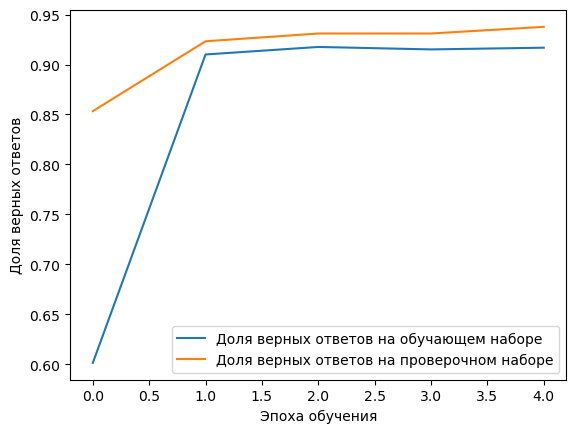

In [423]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Сеть LSTM

In [424]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(8, activation='softmax'))

In [425]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [426]:
history_lstm = model_lstm.fit(X_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/10
64/64 [==============================] - 23s 164ms/step - loss: 1.8464 - accuracy: 0.3800 - val_loss: 1.5033 - val_accuracy: 0.6144
Epoch 2/10
64/64 [==============================] - 7s 102ms/step - loss: 1.1736 - accuracy: 0.6377 - val_loss: 0.8494 - val_accuracy: 0.7833
Epoch 3/10
64/64 [==============================] - 7s 102ms/step - loss: 0.7298 - accuracy: 0.8103 - val_loss: 0.5638 - val_accuracy: 0.8767
Epoch 4/10
64/64 [==============================] - 7s 102ms/step - loss: 0.5134 - accuracy: 0.8913 - val_loss: 0.3919 - val_accuracy: 0.9378
Epoch 5/10
64/64 [==============================] - 6s 102ms/step - loss: 0.3653 - accuracy: 0.9147 - val_loss: 0.2837 - val_accuracy: 0.9211
Epoch 6/10
64/64 [==============================] - 6s 93ms/step - loss: 0.2815 - accuracy: 0.9151 - val_loss: 0.2198 - val_accuracy: 0.9378
Epoch 7/10
64/64 [==============================] - 6s 100ms/step - loss: 0.2514 - accuracy: 0.9170 - val_loss: 0.1991 - val_accuracy: 0.9378
Epoch 

### Смотрим переобучение

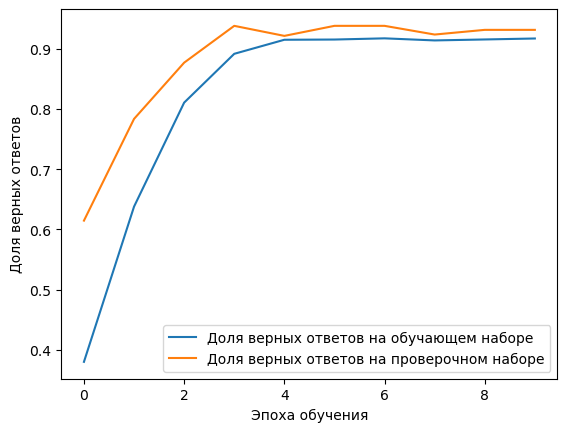

In [427]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Сеть GRU

In [428]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(32))
model_gru.add(GRU(16))
model_gru.add(Dense(8, activation='softmax'))

In [429]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [430]:
model_gru.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 32)           320000    
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dense_19 (Dense)            (None, 8)                 136       
                                                                 
Total params: 322,536
Trainable params: 322,536
Non-trainable params: 0
_________________________________________________________________


In [431]:
history_gru = model_gru.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/5
64/64 [==============================] - 25s 137ms/step - loss: 1.8608 - accuracy: 0.4676 - val_loss: 1.5193 - val_accuracy: 0.6978
Epoch 2/5
64/64 [==============================] - 7s 102ms/step - loss: 1.0553 - accuracy: 0.7737 - val_loss: 0.6370 - val_accuracy: 0.8411
Epoch 3/5
64/64 [==============================] - 7s 106ms/step - loss: 0.5353 - accuracy: 0.8679 - val_loss: 0.4101 - val_accuracy: 0.8944
Epoch 4/5
64/64 [==============================] - 7s 102ms/step - loss: 0.3858 - accuracy: 0.9096 - val_loss: 0.3018 - val_accuracy: 0.9211
Epoch 5/5
64/64 [==============================] - 6s 99ms/step - loss: 0.3057 - accuracy: 0.9153 - val_loss: 0.2508 - val_accuracy: 0.9211


### Смотрим переобучение

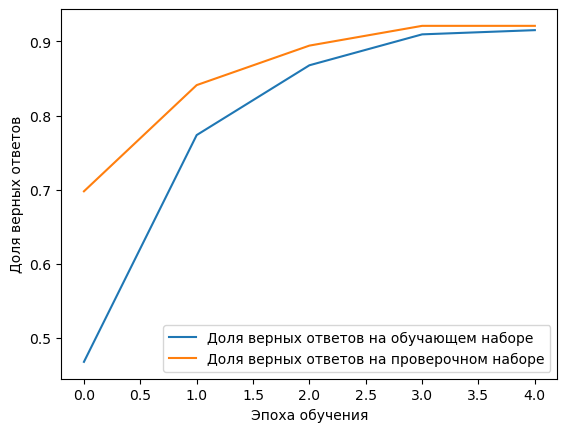

In [432]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Свёрточная сеть

In [433]:
model_cnn.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 2s 47ms/step - loss: 0.1822 - accuracy: 0.9240


[0.18216225504875183, 0.9240000247955322]

### Сеть LSTM

In [434]:
model_lstm.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 6s 60ms/step - loss: 0.1998 - accuracy: 0.9270


[0.19979402422904968, 0.9269999861717224]

### Сеть GRU

In [435]:
model_gru.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 5s 46ms/step - loss: 0.2655 - accuracy: 0.9240


[0.26548585295677185, 0.9240000247955322]

### Проверка документа на фразе

In [508]:
text = """Отдел внедрения Департамента внедрения и обслуживания
О закупке
Внести изменения в ОРД согласно прилагаемому Перечню.
ПЕРЕЧЕНЬ ИЗМЕНЕНИЙ, ВНОСИМЫХ В ОРД Контроль над выполнением вышеуказанного
поручения возложить на администратора вычислительной сети Турова Савву.
Определить срок исполнения задачи вплоть до 20 декабря 03. 1. пункт 2.4.1.3 изложить в следующей редакции:
"2.4.1.3. Входящие документы на иностранных языках регистрируются только после осуществления
их перевода в сроки, указанные в пункте 2.4.1.2, за исключением документов, поступающих из
межгосударственных органов, иностранных и международных (межгосударственных) судов,
иностранных и международных третейских судов (арбитражей) по вопросам обеспечения
представительства и защиты интересов Российской Федерации, которые без перевода на русский язык
регистрируются в отделе документационного обеспечения Главного управления международно-
правового сотрудничества." Определить срок исполнения задачи вплоть до 06 февраля 2014 года.
Контроль над выполнением задачи возложить на системного аналитика Сыроварова Акифа.
i). Внести в Регламент, утвержденный приказом Генерального директора от 11.05.2016
N 276, изменение, исключив из пункта 1.11 слова "а также деятельность Руководителя удаленного
офиса".Ответственность за исполнение задачи возложить на Контент менеджера Роговцова Беньямина.
Установить срок выполнения задачи до 19.08.22.
"""

In [142]:
directory = 'hackaton_2023_01/task_3/full_dataset/docx/'
series = []
filesText = []

for fileIndex in range(1):
    name = str(fileIndex) + '.docx'
    fileText = ''

    document = Document(directory + name)
    for paragraph in document.paragraphs:
        fileText += paragraph.text + '\n'
    print(fileText)
    filesText.append(fileText)


ООО "Мегасофт"


Приказ
Для организации мероприятия "День заказчика" приказываю:
a. Закупить книги. Срок завершения: 19 апр 15.
Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.
и.о. генерального директора Сердитый А.И.
11 апреля 2013 года





In [133]:
sequence = tokenizer.texts_to_sequences([filesText])

In [134]:
data = utils.pad_sequences(sequence, maxlen=max_review_len)

In [135]:
result = model_cnn.predict(data)

1/1 [==============================] - 0s 69ms/step


In [136]:
np.round(result, 3)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [442]:
classes_dep

{'Административно-хозяйственный отдел': 1,
 'Бухгалтерия': 2,
 'Отдел эксплуатации': 3,
 'Отдел тестирования': 4,
 'Отдел архитектуры': 5,
 'Отдел проектирования': 6,
 'Служба ИТ': 7,
 'Отдел разработки систем': 8}

### Находим уникальные значения департаментов.

In [443]:
departments_set = set(DEPARTMENTS)
departments_Unique_list = list(departments_set)
departments_Unique_list

['Административно-хозяйственный отдел',
 'Бухгалтерия',
 'Отдел эксплуатации',
 'Отдел тестирования',
 'Отдел архитектуры',
 'Отдел проектирования',
 'Служба ИТ',
 'Отдел разработки систем']

### Строим однонаправленный граф.

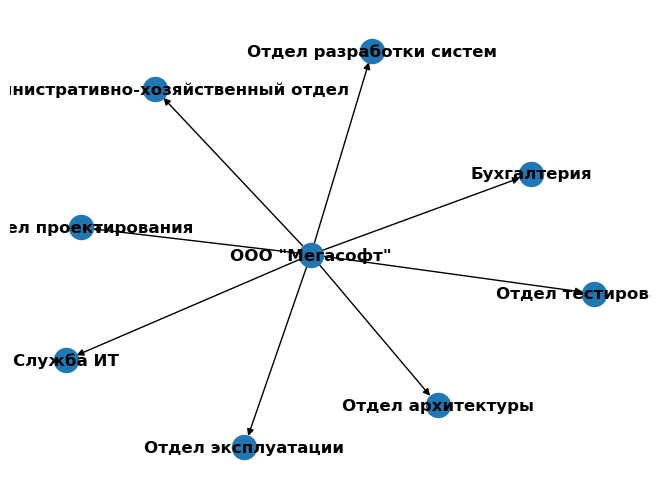

In [444]:
DG = nx.DiGraph()


DG.add_edge('ООО "Мегасофт"', departments_Unique_list[0]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[1]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[2]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[3]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[4]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[5]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[6]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[7]) 

nx.draw(DG, with_labels=True, font_weight='bold')

### Создаём мешок слов

In [445]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results